In [ ]:
install.packages(c("forecast", "tsibble", "psych", "tseries", "rugarch","tseries","FinTS","zoo"))

Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [ ]:
library(tidyverse)
library(forecast)
library(tsibble)
library(psych)
library(tseries)
library(rugarch)
library(TTR)
library(tseries)
library(FinTS)
library(zoo)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.6
✔ forcats   1.0.1     ✔ stringr   1.6.0
✔ ggplot2   4.0.1     ✔ tibble    3.3.0
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.2.0     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 

Registered S3 method overwritten by 'tsibble':
  method               from 
  as_tibble.grouped_df dplyr


Attaching package: ‘tsibble’


The following object is masked from ‘package:lubridate’:

    interval


The following objects are masked from ‘package:base’:

    intersect, setdiff, union



Attaching package: ‘psych’


The following objects are masked from ‘package:gg

### **Import Data**

In [ ]:
fx_ts <- read_csv("dataset_fx_returns (1).csv") %>%
  pull(returns) %>%
  ts(frequency = 1)

stock_ts <- read_csv("dataset_stock_returns (2).csv") %>%
  pull(returns) %>%
  ts(frequency = 1)

Rows: 800 Columns: 1
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (1): returns

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 1000 Columns: 1
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (1): returns

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


### **Visual Exploration of Volatility**

* Plot each dataset’s returns series and rolling standard deviation.
* Examine and describe visual indicators of volatility clustering.
* Plot ACF of squared returns to confirm presence of heteroskedasticity.



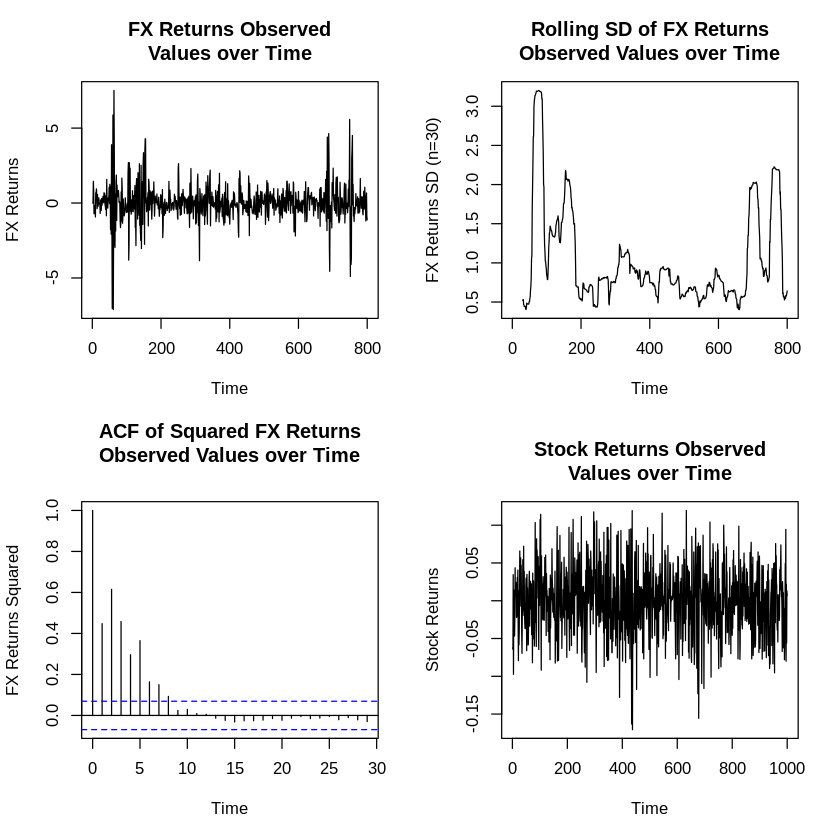

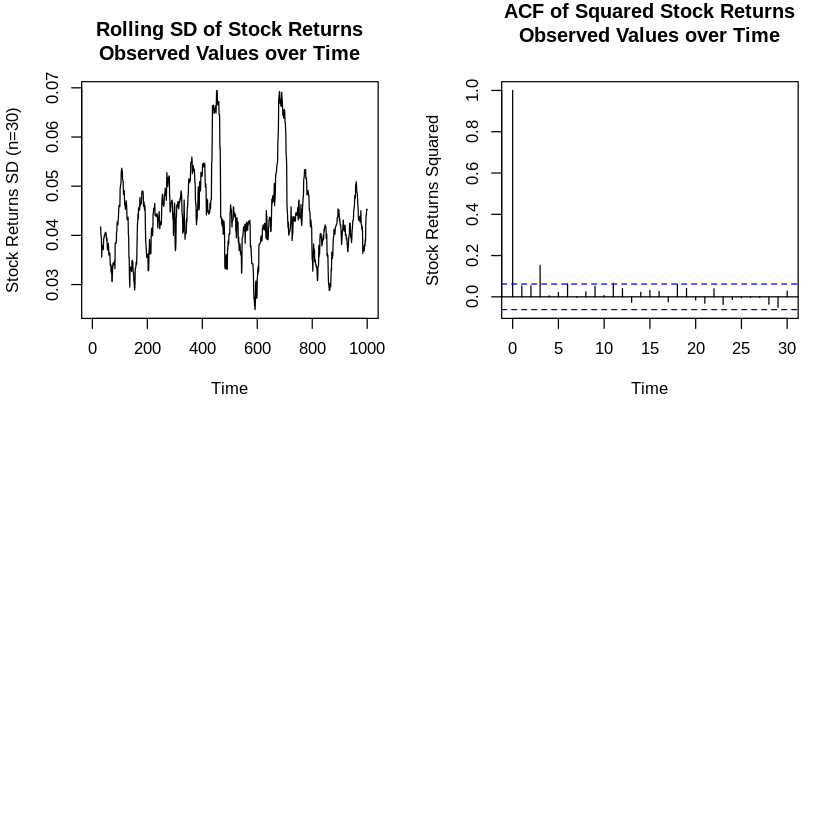

In [ ]:
rolling_fx <- runSD(fx_ts,n=30)
rolling_stock <- runSD(stock_ts,n=30)

fx_sq <- fx_ts^2
stock_sq <- stock_ts^2

par(mfrow = c(2, 2))
plot(fx_ts,
     main = "FX Returns Observed\nValues over Time",
     ylab = "FX Returns",
     xlab = "Time")
plot(rolling_fx,
     main = "Rolling SD of FX Returns\nObserved Values over Time",
     ylab = "FX Returns SD (n=30)",
     xlab = "Time")
acf(fx_sq,
     main = "ACF of Squared FX Returns\nObserved Values over Time",
     ylab = "FX Returns Squared",
     xlab = "Time")

plot(stock_ts,
     main = "Stock Returns Observed\nValues over Time",
     ylab = "Stock Returns",
     xlab = "Time")
plot(rolling_stock,
     main = "Rolling SD of Stock Returns\nObserved Values over Time",
     ylab = "Stock Returns SD (n=30)",
     xlab = "Time")
acf(stock_sq,
     main = "ACF of Squared Stock Returns\nObserved Values over Time",
     ylab = "Stock Returns Squared",
     xlab = "Time")

Based on the plots shown above we can observe that the rolling standard deviation of the FX returns is very volatile wherein it shows itself to have non-consistent values. Moreover, the ACF plot of it shows that the dependence of future values are heavily influenced by a lot of past values, given that the significance is sustained over 5 lag. In terms of stock returns we can observe that the rolling standard deviation is less volatile; this can also be inferred through the original plot where stock returns are centered around a given value. Based on the ACF plot of the stock returns, we can observe that it only depends on the first lag of the data, which indicates that the stock returns exhibit limited autocorrelation and are largely driven by short-term dynamics, suggesting a weaker persistence structure compared to FX returns.

### **Model Estimation**
* For each dataset, fit 1-2 volatility models:
* Record estimated parameters, standard errors, and information criteria (AIC, BIC).

In [ ]:
garch_fx <- ugarchspec(
  variance.model = list(model = "sGARCH", garchOrder = c(1, 1)),
  mean.model     = list(armaOrder = c(0, 0)),
  distribution.model = "norm"
)

fit_garch_fx <- ugarchfit(spec = garch_fx, data = fx_ts)
fit_garch_fx


*---------------------------------*
*          GARCH Model Fit        *
*---------------------------------*

Conditional Variance Dynamics 	
-----------------------------------
GARCH Model	: sGARCH(1,1)
Mean Model	: ARFIMA(0,0,0)
Distribution	: norm 

Optimal Parameters
------------------------------------
        Estimate  Std. Error  t value Pr(>|t|)
mu     -0.008352    0.020984 -0.39803  0.69061
omega   0.122907    0.019934  6.16578  0.00000
alpha1  0.623895    0.075340  8.28104  0.00000
beta1   0.335891    0.048213  6.96679  0.00000

Robust Standard Errors:
        Estimate  Std. Error  t value Pr(>|t|)
mu     -0.008352    0.022058 -0.37864  0.70496
omega   0.122907    0.019931  6.16665  0.00000
alpha1  0.623895    0.076445  8.16141  0.00000
beta1   0.335891    0.044821  7.49400  0.00000

LogLikelihood : -974.8903 

Information Criteria
------------------------------------
                   
Akaike       2.4472
Bayes        2.4706
Shibata      2.4472
Hannan-Quinn 2.4562

Weighted

The model used for the fx returns was a GARCH model due to the sustained volatility over a long period of time, to which ARCH cannot capture. Its model estimates shows that the average is non significant, but its varaince is significant, thus showing majority of the predictions are directly because of the variance. In terms of the information critereon it shows it self to have a very low value, which is almost close to zero, indicating a very good fit. The Ljung test was performed in order to determine how well the model modeled the data. The Ljung test for the residuals is about the arima model which shows that there is no more autocorrolation captured within the model which is a good thing. However, when it comes to the squared residuals, this indicates how much of the variance is captured and if there is still autocorrolation based on that variance. The Ljung shows a significance, idicating that there is still unexplained varaince by the model. The ARCH LM Tests shows most of the heteroskadisticity is captured within the model. Nyblom stability test shows that the values of the average and variances are stable over time. Lastly, the sign bias test indicates symmetric volatility responses to positive and negative shocks, validating the use of a standard GARCH specification, while the adjusted Pearson goodness-of-fit test suggests that the assumed normal distribution adequately captures the standardized residuals.

In [ ]:
arch_stock <- ugarchspec(
  variance.model = list(model = "sGARCH", garchOrder = c(1, 0)),
  mean.model     = list(armaOrder = c(0, 0)),
  distribution.model = "norm"
)

fit_arch_stock <- ugarchfit(spec = arch_stock, data = stock_ts)
fit_arch_stock


*---------------------------------*
*          GARCH Model Fit        *
*---------------------------------*

Conditional Variance Dynamics 	
-----------------------------------
GARCH Model	: sGARCH(1,0)
Mean Model	: ARFIMA(0,0,0)
Distribution	: norm 

Optimal Parameters
------------------------------------
        Estimate  Std. Error   t value Pr(>|t|)
mu      0.000086    0.001399  0.061306  0.95112
omega   0.001849    0.000108 17.073159  0.00000
alpha1  0.064942    0.039971  1.624731  0.10422

Robust Standard Errors:
        Estimate  Std. Error   t value Pr(>|t|)
mu      0.000086    0.001385  0.061944  0.95061
omega   0.001849    0.000121 15.330033  0.00000
alpha1  0.064942    0.041686  1.557887  0.11926

LogLikelihood : 1695.782 

Information Criteria
------------------------------------
                    
Akaike       -3.3856
Bayes        -3.3708
Shibata      -3.3856
Hannan-Quinn -3.3800

Weighted Ljung-Box Test on Standardized Residuals
------------------------------------
   

The model used for modeling the stock returns is using a ARCH model because based on the plots show that the variance is only sustained over a very short period of time which is perfect for an ARCH model. The significant ω indicates that stock returns have a meaningful baseline variance, while the weak and insignificant α₁ shows that past shocks barely influence current volatility, implying that variance is largely driven by the global variance rather than short-term clustering. Based on the Ljung test it shows that it is not significant indicating that no autocorrolation is present within the model, however, the Ljung test of the squared residials shows that it is significant at higher lag values, indicating that there is volatility that was not captured by our ARCH model, given that it is present beyond a singular lag.  Based on the model parameters are stable, the residuals follow a normial distribution, and it is symmetric. An important  indicator is the ARCH test which indicates that are remaining ARCH effects after fitting ARCH(1).

### **Diagnostics & Volatility Interpretation**
* Plot conditional volatility and compare across models.
* Analyze residuals for remaining ARCH effects (using ACF of residuals squared or ARCH-LM test).
* Comment on which model better captures volatility persistence and asymmetry.

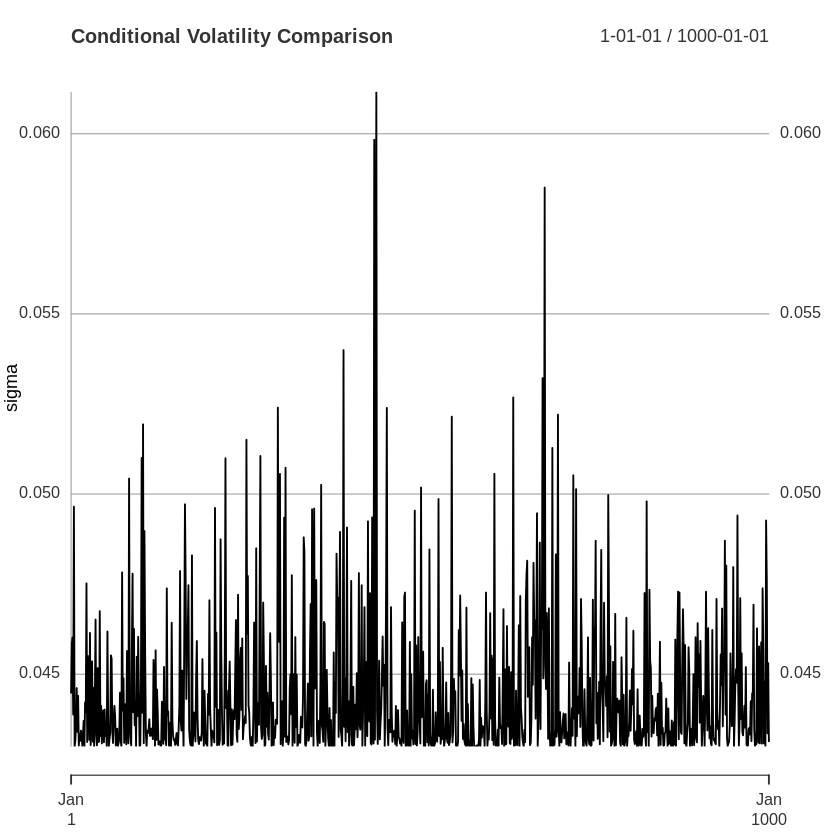

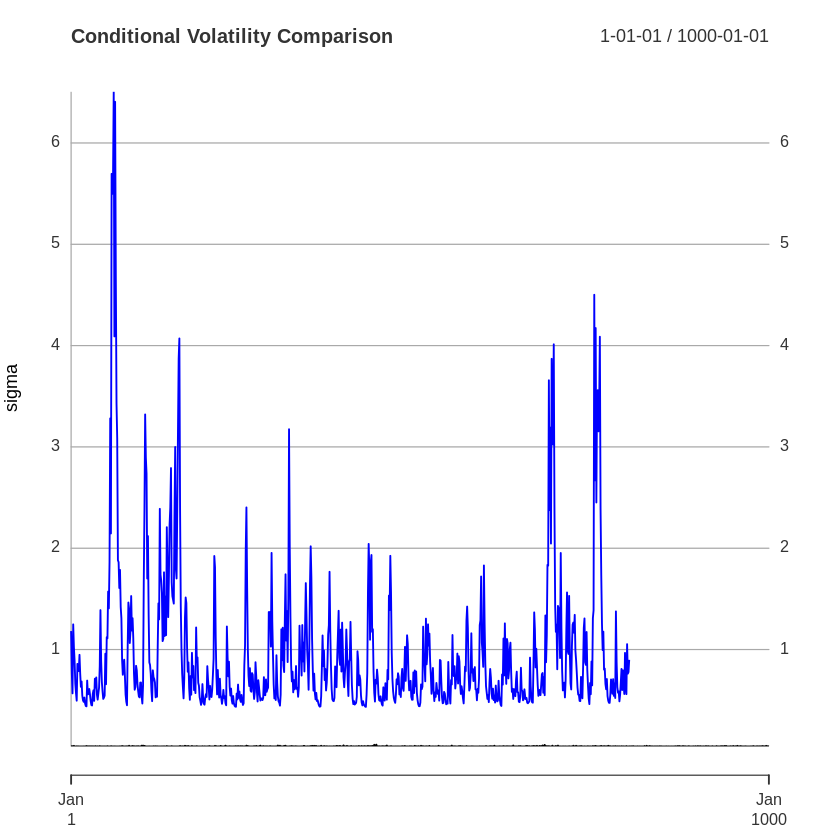

In [ ]:
vol_garch_fx <- sigma(fit_garch_fx)
vol_arch_stock <- sigma(fit_arch_stock)

plot(vol_arch_stock, type="l", main="Conditional Volatility Comparison",
     ylab="sigma", xlab="Time", lwd=1.5)
lines(vol_garch_fx, col="blue", lwd=1.5)

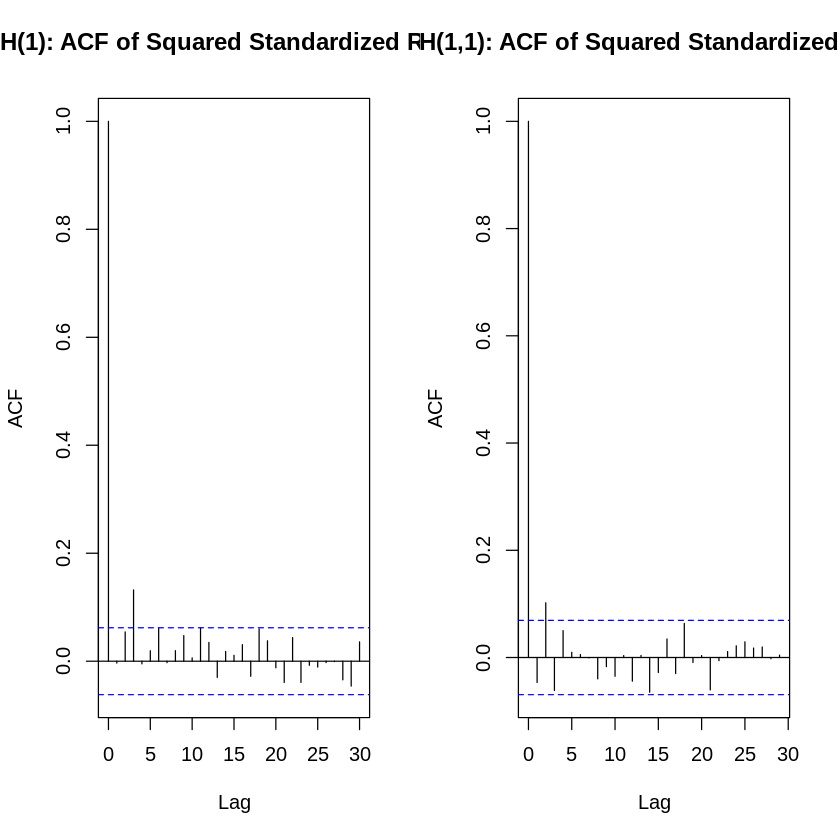

In [ ]:
resid_garch <- residuals(fit_garch_fx, standardize = TRUE)
resid_arch <- residuals(fit_arch_stock, standardize = TRUE)

par(mfrow=c(1,2))
acf(resid_arch^2, main="ARCH(1): ACF of Squared Standardized Residuals")
acf(resid_garch^2, main="GARCH(1,1): ACF of Squared Standardized Residuals")

In [ ]:
cat("ARCH-LM Test for ARCH(1)\n")
print(ArchTest(resid_arch))

cat("ARCH-LM Test for GARCH(1,1)\n")
print(ArchTest(resid_garch))

ARCH-LM Test for ARCH(1)

	ARCH LM-test; Null hypothesis: no ARCH effects

data:  resid_arch
Chi-squared = 27.213, df = 12, p-value = 0.007198

ARCH-LM Test for GARCH(1,1)

	ARCH LM-test; Null hypothesis: no ARCH effects

data:  resid_garch
Chi-squared = 17.887, df = 12, p-value = 0.1192



In [ ]:
coef_arch <- coef(fit_arch_stock)
coef_garch <- coef(fit_garch_fx)

alpha_arch <- coef_arch["alpha1"]
alpha_garch <- coef_garch["alpha1"]
beta_garch  <- coef_garch["beta1"]

persistence_arch  <- alpha_arch
persistence_garch <- alpha_garch + beta_garch

cat("ARCH(1) persistence:", persistence_arch, "\n")
cat("GARCH(1,1) persistence:", persistence_garch, "\n")

ARCH(1) persistence: 0.06494171 
GARCH(1,1) persistence: 0.9597853 


Identifying the conditional volatility shows that the range of the ARCH model of stock returns in contrast to the GARCH model has a very short variance range indicating that shocks to stock returns have a minimal and short-lived impact on future volatility, whereas FX returns modeled by GARCH exhibit large, persistent volatility clusters that carry over multiple periods. Further, acf plots shows that most of the volatility clustering was removed, with only the first lag being consistently significant. Although some minor lags are significant indicating higher level of ARCH/GARCH might be appropriate if percision is relevant. Lastly, persistance shows how much is the variance sustained. The test shows that the ARCH has a low persistance while the GARCH has a very high persistance which is consistent to our previous analyses.

### **Volatility Forecasting**
* Forecast conditional volatility for 10 future periods for each dataset.
* Plot the forecasted volatility path with confidence intervals.
* Explain what happens to volatility over the forecast horizon (does it decay, persist, or show asymmetry?).

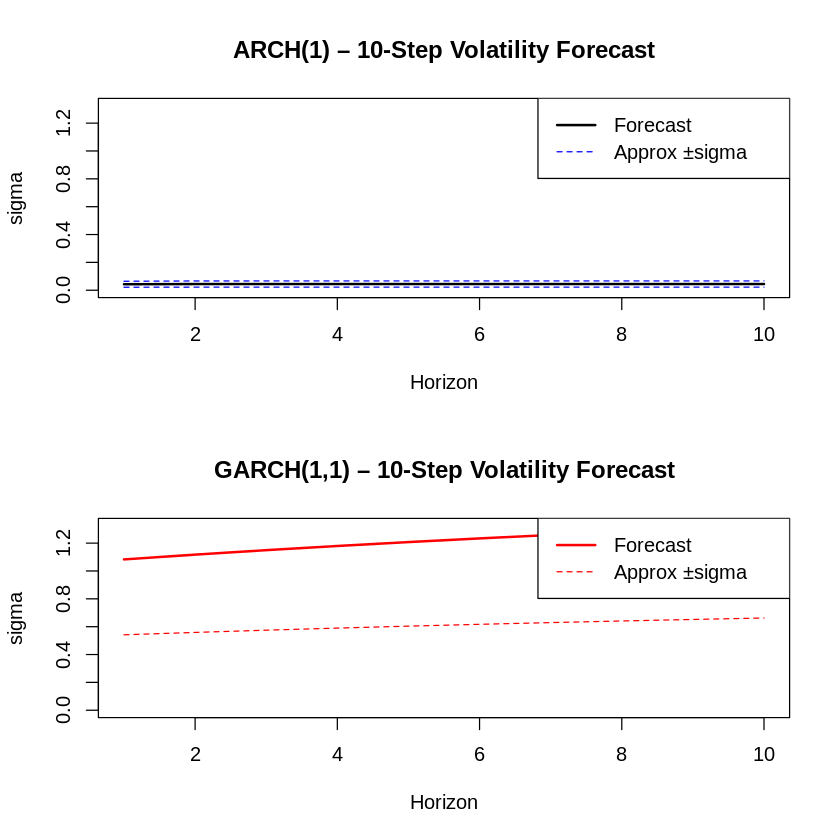

In [ ]:
forecast_arch  <- ugarchforecast(fit_arch_stock, n.ahead = 10)
forecast_garch <- ugarchforecast(fit_garch_fx, n.ahead = 10)

vol_arch  <- sigma(forecast_arch)
vol_garch <- sigma(forecast_garch)

h <- 1:10

par(mfrow=c(2,1))

plot(h, vol_arch, type="l", lwd=2,
     main="ARCH(1) – 10-Step Volatility Forecast",
     xlab="Horizon", ylab="sigma",
     ylim=c(0, max(vol_arch, vol_garch)))
lines(h, vol_arch*0.5, lty=2, col="blue")
lines(h, vol_arch*1.5, lty=2, col="blue")
legend("topright", legend=c("Forecast","Approx ±sigma"), lty=c(1,2), col=c("black","blue"), lwd=c(2,1))

plot(h, vol_garch, type="l", lwd=2, col="red",
     main="GARCH(1,1) – 10-Step Volatility Forecast",
     xlab="Horizon", ylab="sigma",
     ylim=c(0, max(vol_arch, vol_garch)))
lines(h, vol_garch*0.5, lty=2, col="red")
lines(h, vol_garch*1.5, lty=2, col="red")
legend("topright", legend=c("Forecast","Approx ±sigma"), lty=c(1,2), col=c("red","red"), lwd=c(2,1))


The plots shows the volatility of the predicted outcomes of the ARCH and GARCH model wherein we can observe due to the data having unsustained varaince the variance of the model produces is near constant zero, while the variance of the predicted outcomes of the GARCH model is rising as the horizon gets larger but it still exibits a slow pace of increase.